<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgettingRicc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun  3 09:29:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    70W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [3]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
# 	                                      transforms.Pad(4), # Add padding
# 	                                      transforms.RandomCrop(32),# Crops a random squares of the image
# 	                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
# 	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 	])

# eval_transform = transforms.Compose([
# 	                                      transforms.ToTensor(),
# 	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) ])





batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_raw = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
for i in range(len(testset_raw)):
  if(i==0):
    testset = [[testset_raw[i][0], testset_raw[i][1]]]
  else:
    testset.append([testset_raw[i][0], testset_raw[i][1]])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK

In [4]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    # def addOutputNodes(self, num_new_outputs):
    #     in_features = self.fc.in_features
    #     out_features = self.fc.out_features
    #     weight = self.fc.weight.data

    #     self.fc = nn.Linear(in_features, out_features + num_new_outputs)

    #     #xavier initialization
    #     xavier_uniform_(self.fc.weight)
        
    #     self.fc.weight.data[:out_features] = weight
        
def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

In [5]:
class LWF(nn.Module):
  def __init__(self, feature_size, n_classes):
    super(LWF,self).__init__()
    self.feature_extractor = resnet32()
    self.feature_extractor.fc = nn.Linear(self.feature_extractor.fc.in_features, feature_size)
    self.bn =  nn.BatchNorm1d(feature_size, momentum=0.9)
    self.ReLU = nn.ReLU()

    self.fc = nn.Linear(feature_size, n_classes, bias = False)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.bn(x)
    x = self.ReLU(x)
    x = self.fc(x)

    return x

  def increment_classes(self, n):
    """Add n classes in the final fc layer"""
    in_features = self.fc.in_features
    out_features = self.fc.out_features
    weight = self.fc.weight.data

    #xavier initialization
    # xavier_uniform_(self.fc.weight)

    self.fc = nn.Linear(in_features, out_features + n, bias = False)
    self.fc.weight.data[:out_features] = weight

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
feature_size = 2048
n_classes = 10
net = LWF(feature_size, n_classes)
net.to(device)

LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, 

### LOSS & PARAMETERS

In [7]:
lr = 0.1
decay = 0.00001
epochs = 10
momentum = 0.9
factor = 5

In [8]:
import torch.optim as optim
import torch.nn as nn

bceLoss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING BCE LOSS

In [9]:
# def training(trainloader, iteration, network, device, epochs, num_classes):

#   num_classes_till_previous_step = iteration * num_classes
#   num_current_classes = num_classes_till_previous_step + num_classes
#   total_classes = 100

#   distillation_loss = 0

#   old_net = copy.deepcopy(network)
#   old_net.eval()
  
#   if (iteration != 0):
#     # add 10 output nodes to the network
#     network.increment_classes(num_classes)
#     network.to(device)

#   optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
 
 
#   #train the network
#   for epoch in range(epochs):
#     if (epoch == 49 or epoch == 63):
#      optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#       inputs = data[0].to(device)
#       labels = data[1].to(device)
#       optimizer.zero_grad()
#       logits = network.forward(inputs)
#       distilled_targets = get_one_hot(labels, num_current_classes, device)
      
#       if iteration > 0:
#         logits_old = old_net(inputs)
#         distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)

#       loss = bceLoss(logits, distilled_targets) #* (num_current_classes / total_classes)

#       # redesign the weights evaluating the performance of the network
#       loss.backward()
#       # update parameters
#       optimizer.step()

#       running_loss += loss.item()
#       if i % 20 == 19:    
#         print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#         running_loss = 0.0

#   return network

In [10]:
# def get_one_hot(target,num_class, device):
#   one_hot=torch.zeros(target.shape[0],num_class).to(device)
#   one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
#   return one_hot

### training (bce loss)

In [11]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  
  num_classes_till_previous_step = iteration * num_classes
  num_current_classes = num_classes_till_previous_step + num_classes
  total_classes = 100

  distillation_loss = 0
  
  old_net = copy.deepcopy(network)
  old_net.eval()
  
  if (iteration != 0):
    # add 10 output nodes to the network
    network.increment_classes(num_classes)
    network.to(device)

  net = network.feature_extractor
  net = net.to(device)

  optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
 
  
  #train the network
  for epoch in range(epochs):
    if (epoch == 49 or epoch == 63):
     optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs = data[0].to(device)
      labels = data[1].to(device)

      net.train()

      optimizer.zero_grad()

      logits = network.forward(inputs)

      distilled_targets = get_one_hot(labels, num_current_classes, device)
      
      if iteration > 0:
        logits_old = old_net(inputs)
        distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)


      loss = bceLoss(logits, distilled_targets) * (num_current_classes / total_classes)

      # redesign the weights evaluating the performance of the network
      loss.backward()
      # update parameters
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0


In [12]:
def get_one_hot(target,num_class, device):
  one_hot=torch.zeros(target.shape[0],num_class).to(device)
  one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
  return one_hot

### TEST (CONFUSION EACH STEP)



In [13]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  network.eval()
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(torch.softmax(network.forward(images), dim=1), dim=1, keepdim=False)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


          print("Tot images for test: ", labels.size(0))
          print("Correct images classified: ", correct)

          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### RANDOM CLASSES


EXECUTION

In [14]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]
for j in range(len(testset)):
  testset[j][1] = dict_classes[testset[j][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
train_set lenght:  5000
[1,    20] loss: 0.040
[1,    40] loss: 0.031
[2,    20] loss: 0.028
[2,    40] loss: 0.027
[3,    20] loss: 0.026
[3,    40] loss: 0.025
[4,    20] loss: 0.024
[4,    40] loss: 0.024
[5,    20] loss: 0.023
[5,    40] loss: 0.023
[6,    20] loss: 0.022
[6,    40] loss: 0.022
[7,    20] loss: 0.022
[7,    40] loss: 0.021
[8,    20] loss: 0.021
[8,    40] loss: 0.020
[9,    20] loss: 0.020
[9,    40] loss: 0.020
[10,    20] loss: 0.019
[10,    40] loss: 0.019
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

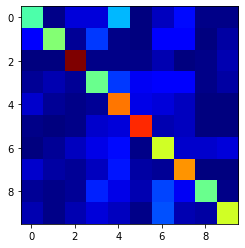

Accuracy of the network on the 0 iteration: 57 %
Train the network, iteration:  1  on classes:  range(10, 20)
train_set lenght:  5000
[1,    20] loss: 0.058
[1,    40] loss: 0.048
[2,    20] loss: 0.046
[2,    40] loss: 0.045
[3,    20] loss: 0.043
[3,    40] loss: 0.043
[4,    20] loss: 0.042
[4,    40] loss: 0.042
[5,    20] loss: 0.041
[5,    40] loss: 0.040
[6,    20] loss: 0.040
[6,    40] loss: 0.040
[7,    20] loss: 0.039
[7,    40] loss: 0.039
[8,    20] loss: 0.038
[8,    40] loss: 0.038
[9,    20] loss: 0.037
[9,    40] loss: 0.037
[10,    20] loss: 0.036
[10,    40] loss: 0.037
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

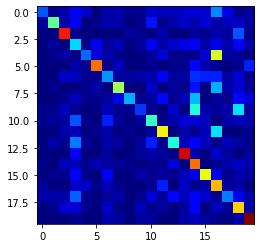

Accuracy of the network on the 1 iteration: 41 %
Train the network, iteration:  2  on classes:  range(20, 30)
train_set lenght:  5000
[1,    20] loss: 0.080
[1,    40] loss: 0.068
[2,    20] loss: 0.067
[2,    40] loss: 0.066
[3,    20] loss: 0.065
[3,    40] loss: 0.066
[4,    20] loss: 0.065
[4,    40] loss: 0.064
[5,    20] loss: 0.063
[5,    40] loss: 0.063
[6,    20] loss: 0.063
[6,    40] loss: 0.063
[7,    20] loss: 0.062
[7,    40] loss: 0.062
[8,    20] loss: 0.061
[8,    40] loss: 0.062
[9,    20] loss: 0.061
[9,    40] loss: 0.060
[10,    20] loss: 0.060
[10,    40] loss: 0.061
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

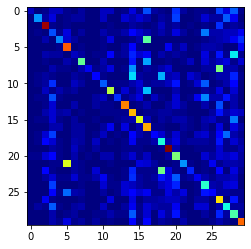

Accuracy of the network on the 2 iteration: 29 %
Train the network, iteration:  3  on classes:  range(30, 40)
train_set lenght:  5000
[1,    20] loss: 0.099
[1,    40] loss: 0.088
[2,    20] loss: 0.084
[2,    40] loss: 0.084
[3,    20] loss: 0.083
[3,    40] loss: 0.083
[4,    20] loss: 0.082
[4,    40] loss: 0.082
[5,    20] loss: 0.081
[5,    40] loss: 0.081
[6,    20] loss: 0.080
[6,    40] loss: 0.081
[7,    20] loss: 0.080
[7,    40] loss: 0.080
[8,    20] loss: 0.079
[8,    40] loss: 0.078
[9,    20] loss: 0.078
[9,    40] loss: 0.078
[10,    20] loss: 0.077
[10,    40] loss: 0.077
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

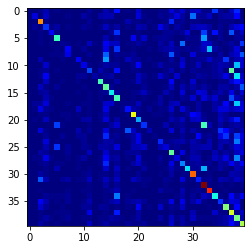

Accuracy of the network on the 3 iteration: 25 %
Train the network, iteration:  4  on classes:  range(40, 50)
train_set lenght:  5000
[1,    20] loss: 0.129
[1,    40] loss: 0.118
[2,    20] loss: 0.115
[2,    40] loss: 0.115
[3,    20] loss: 0.114
[3,    40] loss: 0.114
[4,    20] loss: 0.113
[4,    40] loss: 0.113
[5,    20] loss: 0.111
[5,    40] loss: 0.112
[6,    20] loss: 0.111
[6,    40] loss: 0.110
[7,    20] loss: 0.110
[7,    40] loss: 0.110
[8,    20] loss: 0.109
[8,    40] loss: 0.109
[9,    20] loss: 0.109
[9,    40] loss: 0.109
[10,    20] loss: 0.108
[10,    40] loss: 0.107
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

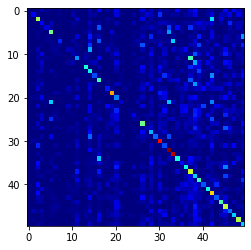

Accuracy of the network on the 4 iteration: 22 %
Train the network, iteration:  5  on classes:  range(50, 60)
train_set lenght:  5000
[1,    20] loss: 0.142
[1,    40] loss: 0.131
[2,    20] loss: 0.129
[2,    40] loss: 0.128
[3,    20] loss: 0.128
[3,    40] loss: 0.128
[4,    20] loss: 0.127
[4,    40] loss: 0.127
[5,    20] loss: 0.127
[5,    40] loss: 0.127
[6,    20] loss: 0.125
[6,    40] loss: 0.126
[7,    20] loss: 0.126
[7,    40] loss: 0.125
[8,    20] loss: 0.125
[8,    40] loss: 0.125
[9,    20] loss: 0.124
[9,    40] loss: 0.125
[10,    20] loss: 0.124
[10,    40] loss: 0.124
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

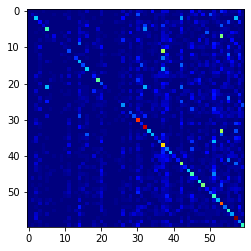

Accuracy of the network on the 5 iteration: 19 %
Train the network, iteration:  6  on classes:  range(60, 70)
train_set lenght:  5000
[1,    20] loss: 0.162
[1,    40] loss: 0.148
[2,    20] loss: 0.146
[2,    40] loss: 0.144
[3,    20] loss: 0.144
[3,    40] loss: 0.143
[4,    20] loss: 0.143
[4,    40] loss: 0.143
[5,    20] loss: 0.142
[5,    40] loss: 0.142
[6,    20] loss: 0.141
[6,    40] loss: 0.141
[7,    20] loss: 0.140
[7,    40] loss: 0.140
[8,    20] loss: 0.140
[8,    40] loss: 0.139
[9,    20] loss: 0.140
[9,    40] loss: 0.141
[10,    20] loss: 0.140
[10,    40] loss: 0.140
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

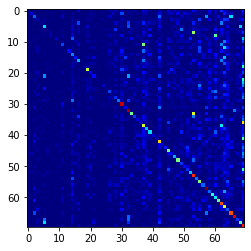

Accuracy of the network on the 6 iteration: 19 %
Train the network, iteration:  7  on classes:  range(70, 80)
train_set lenght:  5000
[1,    20] loss: 0.186
[1,    40] loss: 0.173
[2,    20] loss: 0.169
[2,    40] loss: 0.169
[3,    20] loss: 0.167
[3,    40] loss: 0.168
[4,    20] loss: 0.167
[4,    40] loss: 0.166
[5,    20] loss: 0.166
[5,    40] loss: 0.166
[6,    20] loss: 0.165
[6,    40] loss: 0.164
[7,    20] loss: 0.165
[7,    40] loss: 0.164
[8,    20] loss: 0.164
[8,    40] loss: 0.164
[9,    20] loss: 0.162
[9,    40] loss: 0.165
[10,    20] loss: 0.162
[10,    40] loss: 0.164
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

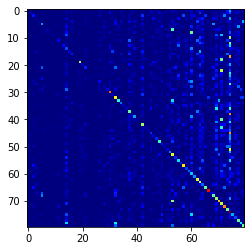

Accuracy of the network on the 7 iteration: 17 %
Train the network, iteration:  8  on classes:  range(80, 90)
train_set lenght:  5000
[1,    20] loss: 0.209
[1,    40] loss: 0.191
[2,    20] loss: 0.187
[2,    40] loss: 0.188
[3,    20] loss: 0.186
[3,    40] loss: 0.184
[4,    20] loss: 0.183
[4,    40] loss: 0.185
[5,    20] loss: 0.183
[5,    40] loss: 0.184
[6,    20] loss: 0.184
[6,    40] loss: 0.182
[7,    20] loss: 0.182
[7,    40] loss: 0.181
[8,    20] loss: 0.182
[8,    40] loss: 0.182
[9,    20] loss: 0.183
[9,    40] loss: 0.181
[10,    20] loss: 0.181
[10,    40] loss: 0.182
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

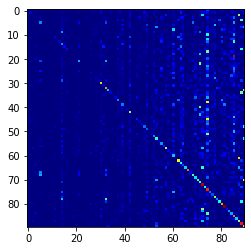

Accuracy of the network on the 8 iteration: 16 %
Train the network, iteration:  9  on classes:  range(90, 100)
train_set lenght:  5000
[1,    20] loss: 0.236
[1,    40] loss: 0.220
[2,    20] loss: 0.216
[2,    40] loss: 0.217
[3,    20] loss: 0.215
[3,    40] loss: 0.215
[4,    20] loss: 0.214
[4,    40] loss: 0.214
[5,    20] loss: 0.212
[5,    40] loss: 0.213
[6,    20] loss: 0.213
[6,    40] loss: 0.211
[7,    20] loss: 0.211
[7,    40] loss: 0.211
[8,    20] loss: 0.211
[8,    40] loss: 0.210
[9,    20] loss: 0.210
[9,    40] loss: 0.211
[10,    20] loss: 0.210
[10,    40] loss: 0.210
LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

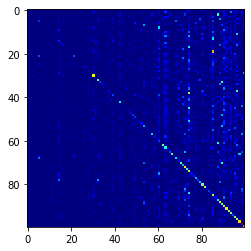

Accuracy of the network on the 9 iteration: 16 %


In [15]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10 
num_classes = 10 
test_iter = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
val_setL = []
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      train_iter.append(trainset[j])
  for l in range(len(testset)):
    if (testset[l][-1] in classes_current_iter):
      test_iter.append(testset[l])

 
  # train_set, val_set = torch.utils.data.random_split(train_iter, [4000, 1000])

  # for z in range(len(val_set)):
  #   val_setL.append(val_set[z])
  


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  # valid_loader = torch.utils.data.DataLoader(val_setL,shuffle = True, batch_size=batch_size, num_workers=2)

 
  test_loader = torch.utils.data.DataLoader(test_iter, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  

  print("train_set lenght: ", len(train_iter))
  # print("val_set length: ", len(val_set))
  # print("val_setL length: ", len(val_setL))


  # Train the network with 10 classes at a time
  training(train_loader, i, net, device, epochs, num_classes)
  # print("after training: ", net.fc.weight.data)

  print(net)
  # Test the network with all classes seen until this iteration on the validation set
  # test(valid_loader, i, net, acc)

  # Test the network with all classes seen until this iteration on the test set
  test(test_loader, i, net, acc) 

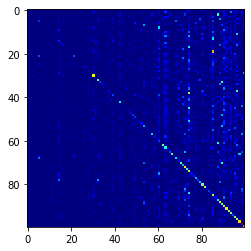

Accuracy of the network: 16 %


In [16]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    
    # calculate outputs by running images through the network
    outputs = net.forward(images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(torch.softmax(net.forward(images), dim=1), dim=1, keepdim=False)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
         
    for t, p in zip(labels.view(-1), predicted.view(-1)):
      confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
plt.show()
print(f'Accuracy of the network: %d %%' % (100 * correct / total))